# QAOA Algorithm for Constrained Optimization: MaxCut Problem

This notebook demonstrates the QAOA algorithm using Classiq. It covers the Max-Cut problem as an example of a combinatorial optimization problem, showcasing how QAOA can be applied to graph-based optimization tasks [[1](#QAOA)]. 

## Introduction

### The Max-Cut Problem  
Given an undirected graph $G = (V, E)$, the goal of the Max-Cut problem is to partition the vertices into two sets such that the number of edges between the sets is maximized.  

**Input:**  
  - $G = (V, E)$: A graph with vertices $V$ and edges $E$.

**Output:** 
  - A partition $S, \bar{S}$ that maximizes the cut value:  
  $$
  \max_{S \subset V} \sum_{(i,j) \in E} (1 - \delta_{s_i, s_j})
  $$
  where $s_i$ represents the subset assignment of vertex $i$, and $\delta_{s_i, s_j}$ is the Kronecker delta function.  

The Max-Cut problem is known to be **NP-complete**.  

**Note:** The Max-Cut problem also has a **weighted version**, where each edge has a weight $w_{ij}$, and the goal is to maximize the weighted sum of cut edges instead of just the count.  


### Set a Specific Problem Instance to Optimize  

We choose a small toy Max-Cut instance using a **5-node graph**:  
- **Vertices:** $V = \{0,1,2,3,4\}$  
- **Edges:** $E = \{(0,1), (0,2), (1,2), (1,3), (2,4), (3,4)\}$  

#### **Optimal Max-Cut Solution**  
A partition that maximizes the number of cut edges:  
- **Set 1:** $\{0, 3\}$  
- **Set 2:** $\{1, 2, 4\}$  

This results in **maximum cut edges between the sets**, showcasing a non-trivial Max-Cut instance.  


## Algorithm description

In this problem, we apply quantum transformations to optimize the Max-Cut objective function.  

A quantum state $|x\rangle$ represents the possible cut assignments of the graph. We use two key transformations in the QAOA process:  

1. **Objective Phase (Analog):**  
   A phase rotation in the Z direction is applied according to the objective value, as done in the vanilla QAOA:  
   $$
   |x\rangle \xrightarrow{U_{\text{o}}(\theta)} e^{i\theta f_{\text{obj}}(x)}|x\rangle
   $$
      The transformation is done easily with the `phase` statement.

2. **Mixing Operator (Digital):**  
   A digital transformation (typically an $X$-rotation) is applied to explore different cut configurations:  
   $$
   U_B(\beta) = e^{-i\beta H_B}, \quad H_B = \sum_i X_i
   $$
   This ensures a balance between exploration and exploitation, helping the quantum algorithm navigate toward better solutions.  

By alternating between these transformations in each QAOA layer, we gradually steer the quantum state toward a cut configuration that **maximizes the number of edges between partitions**.  

This method leverages quantum interference and superposition to enhance optimization, making QAOA a promising approach for solving Max-Cut.  


## Algorithm Implementation using Classiq

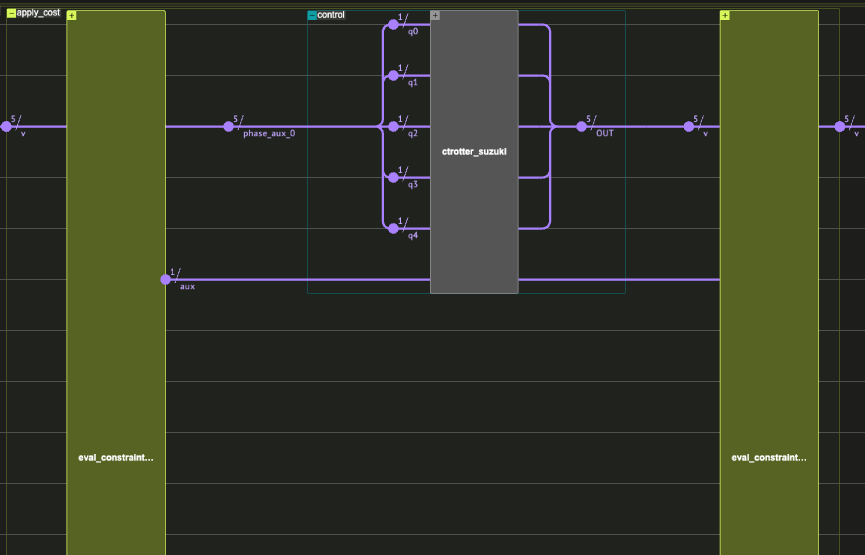

### Define the MaxCut problem


In [20]:
from classiq import *


@qfunc
def cost(gamma: CArray[CReal, 4], v: QArray[QBit, 5]):  # TODO: functionalized
    phase(
        (v[0] * (1 - v[1]) + v[1] * (1 - v[0]))  # edge (0,1)
        + (v[0] * (1 - v[2]) + v[2] * (1 - v[0]))  # edge (0,2)
        + (v[1] * (1 - v[2]) + v[2] * (1 - v[1]))  # edge (1,2)
        + (v[1] * (1 - v[3]) + v[3] * (1 - v[1]))  # edge (1,3)
        + (v[2] * (1 - v[4]) + v[4] * (1 - v[2]))  # edge (2,4)
        + (v[3] * (1 - v[4]) + v[4] * (1 - v[3])),  # edge (3,4)
        gamma,
    )

In [22]:
from classiq import *

p = 4  # Number of Layers


@qfunc
def main(
    gammas: CArray[CReal, 4],
    betas: CArray[CReal, 4],
    v: Output[QArray[QBit, 5]],
):
    allocate(v)
    hadamard_transform(v)
    for i in range(p):
        cost(gammas[i], v)  # Cost
        apply_to_all(lambda q: RX(betas[i], q), v)  # Mixing Layer


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/2tFoZFoqYAPRD2fhPP7Opp0BFG9?version=0.66.1


In [17]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

from classiq.execution import *

NUM_SHOTS = 1000
MAX_ITERATIONS = 60

# start with a linear scheduling guess
initial_params = np.concatenate((np.linspace(0, 1, p), np.linspace(1, 0, p))) * math.pi

cost_trace = []


def evaluate_params(es, params):
    # Split the parameters into two arrays: one for gammas and one for betas
    gammas = params[:4].tolist()
    betas = params[4:].tolist()
    cost_estimation = es.estimate_cost(
        cost_func=lambda state: cost(state["v"]),
        parameters={"gammas": gammas, "betas": betas},
    )
    cost_trace.append(cost_estimation)
    return cost_estimation


es = ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)  # increment progress bar

    final_params = scipy.optimize.minimize(
        fun=lambda params: evaluate_params(es, params),
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    ).x.tolist()

print(f"Optimized parameters: {final_params}")
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

Optimization Progress:   0%|                                           | 0/60 [00:03<?, ?it/s]


AssertionError: 

## Apply Objective Phase controlled on the Contraint predicate result

We wrap the objective `phase` statement with the constraint predicate, so the allocated auxilliary will be release afterwards.
The effective phase will be:
$$
|x\rangle \xrightarrow{U_{\text{o}}(\theta)} 
\begin{cases}
e^{i\theta f_{\text{obj}}(x)} |x\rangle & \text{if } \text{constraint}(x) = 1, \\
|x\rangle & \text{if } \text{constraint}(x) = 0.
\end{cases}
$$

In [3]:
# @qfunc
# def apply_cost(gamma: CReal, v: KnapsackVars) -> None:
#     aux = QBit("aux")
#     within_apply(  # Rotate states per their objective value, if they satisfy the constraint
#         within=lambda: assign(
#             constraint(v), aux
#         ),  # use the digital constraint function
#         apply=lambda: control(aux, lambda: phase(-objective(v), gamma)),
#     )

## Assemble to the full QAOA algorithm

As in the vanilla QAOA, the cost and mixer layers are applied sequentially with varying parameters, that will be set by the classical optimization loop:

In [4]:
# # Unchanged:


# from classiq import *

# @qfunc
# def main(
#     gammas: CArray[CReal, 4],
#     betas: CArray[CReal, 4],
#     v: Output[QArray[QBit, 5]],
# ):
#     allocate(v)
#     hadamard_transform(v)
#     for i in range(4):
#         phase(
#             (v[0]*(1 - v[1]) + v[1]*(1 - v[0]))  # edge (0,1)
#             + (v[0]*(1 - v[2]) + v[2]*(1 - v[0]))  # edge (0,2)
#             + (v[1]*(1 - v[2]) + v[2]*(1 - v[1]))  # edge (1,2)
#             + (v[1]*(1 - v[3]) + v[3]*(1 - v[1]))  # edge (1,3)
#             + (v[2]*(1 - v[4]) + v[4]*(1 - v[2]))  # edge (2,4)
#             + (v[3]*(1 - v[4]) + v[4]*(1 - v[3])), # edge (3,4)
#             gammas[i],
#         )
#         apply_to_all(lambda q: RX(betas[i], q), v)

## Classical Optimization

Now we have a parameteric circuit, that we can sample by providing it the expected parameters, which are an array of size `p*2`.
The `ExecutionSession` object is used in order to execute the circuit with given pararmeters. the method `ExecutionSession.estimate_cost` should be provided with the execution parameters and a `cost_func` for evaluating the cost of a given sample. Notice that the same `objective` function that was use in the quantum `phase` application is used here in the classical post-processing.

For the classical optimizer we use `scipy.optimize.minimize` with the `COBYLA` optimization method, that will be called with the `evaluate_params` function.

In [5]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

from classiq.execution import *

NUM_SHOTS = 1000
MAX_ITERATIONS = 60

# start with a linear scheduling guess
initial_params = np.concatenate((np.linspace(0, 1, p), np.linspace(1, 0, p))) * math.pi

cost_trace = []


def evaluate_params(es, params):
    cost_estimation = es.estimate_cost(
        cost_func=lambda state: cost(state["v"]), parameters={"params": params.tolist()}
    )
    cost_trace.append(cost_estimation)
    return cost_estimation


es = ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)  # increment progress bar

    final_params = scipy.optimize.minimize(
        fun=lambda params: evaluate_params(es, params),
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    ).x.tolist()

print(f"Optimized parameters: {final_params}")
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

Optimization Progress:   0%|                                     | 0/60 [00:02<?, ?it/s]


ClassiqAPIError: User provided different parameters than those included in the circuit. Circuit Parameters are {'gammas_param_3', 'betas_param_1', 'betas_param_2', 'gammas_param_2', 'gammas_param_1', 'betas_param_0', 'gammas_param_0', 'betas_param_3'}, while provided parameters are {'params_param_0', 'params_param_7', 'params_param_3', 'params_param_5', 'params_param_1', 'params_param_6', 'params_param_4', 'params_param_2'}.

Error identifier: E330F07FB-9488-49A6-8570-CE44A6C011D1.
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack

After the optimization, we sample the the circuit with the optimized parameters:

In [ ]:
res = es.sample({"params": final_params})
es.close()

Print the resulting solutions according to the probability:

In [ ]:
sorted_counts = sorted(res.parsed_counts, key=lambda sampled: cost(sampled.state["v"]))
for sampled in sorted_counts:
    v = sampled.state["v"]
    print(
        f"solution={v} probability={sampled.shots/NUM_SHOTS} objective={objective(v)} constraint={constraint(v)}"
    )

## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='knapsack'>[2]</a>: [Knapsack problem (Wikipedia)](https://en.wikipedia.org/wiki/Knapsack_problem)